In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_dev = pd.read_csv("Problema1/data/raw/cell_diagnosis_dev.csv")
df_test = pd.read_csv("Problema1/data/raw/cell_diagnosis_test.csv")

def data_info(df_dev, df_test):
    """Muestra información general del dataset.  
    Params: df_dev (DataFrame), df_test (DataFrame).  
    """
    df = pd.concat([df_dev, df_test])
    print("Fragmento aleatorio de muestras\n", df.sample(7))
    print("\nRango de valores de cada columna\n", df.describe().loc[['min', 'max']])
    print("\nCategorías con valores faltantes\n", df.isna().sum()[df.isna().sum() > 0].to_string())
    print("\nFilas duplicadas:", df.duplicated().sum())

data_info(df_dev, df_test)
df = pd.concat([df_dev, df_test])

df_num = df.select_dtypes(include='number')

# Eliminar filas con NaNs en esas columnas
df_num = df_num.dropna()

# Pairplot
# sns.pairplot(df_num)


Fragmento aleatorio de muestras
        CellSize  CellShape  NucleusDensity  ChromatinTexture  CytoplasmSize  \
177   67.067027   0.474160        1.401723         21.006551            NaN   
1257        NaN   0.411135        1.411529         21.528494      31.981274   
1657  70.909632   0.491913        1.342475               NaN      29.744590   
707   77.304128        NaN        1.436251         23.530536      29.957653   
1108        NaN   0.468509        1.466273         24.022553            NaN   
1448        NaN   3.909374        5.485281         20.438453      28.383473   
117   66.567694   0.514070        1.456688         23.099947      25.806138   

      CellAdhesion  MitosisRate  NuclearMembrane  GrowthFactor  \
177       0.491849     2.886550         2.347743     62.142775   
1257      0.468351          NaN         2.237370     62.769621   
1657      0.475881          NaN         2.410657           NaN   
707       0.441403     2.973143         2.128149     64.242915   
1108

NaNs en todos menos GeneticMutation  
Outliers (valores fuera de rango) en:
Todas. Algunas son valores imposibles (tipo del 0 al 100%, -30) y otras se van mucho de el resto
Outliers que considero imposibles:


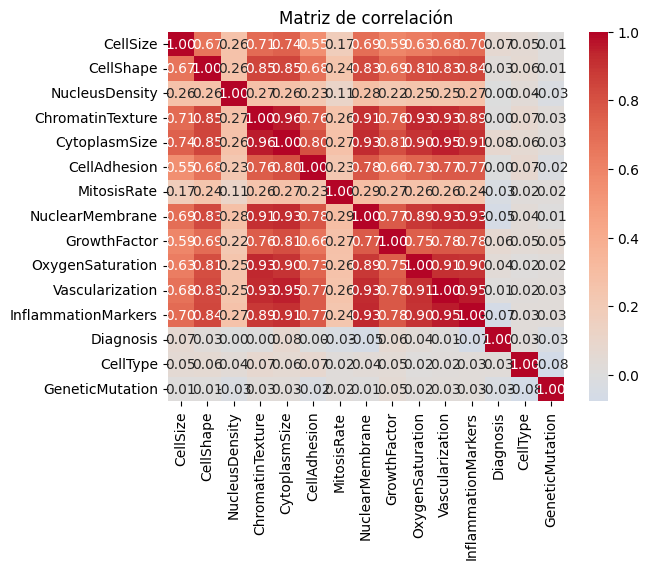

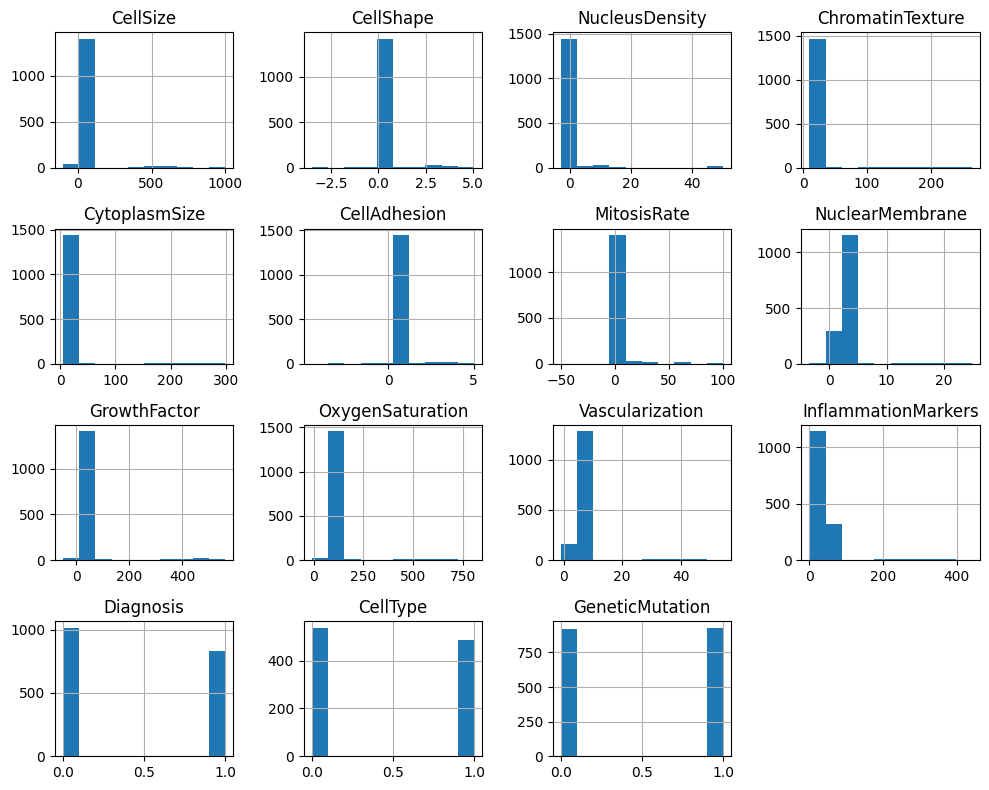

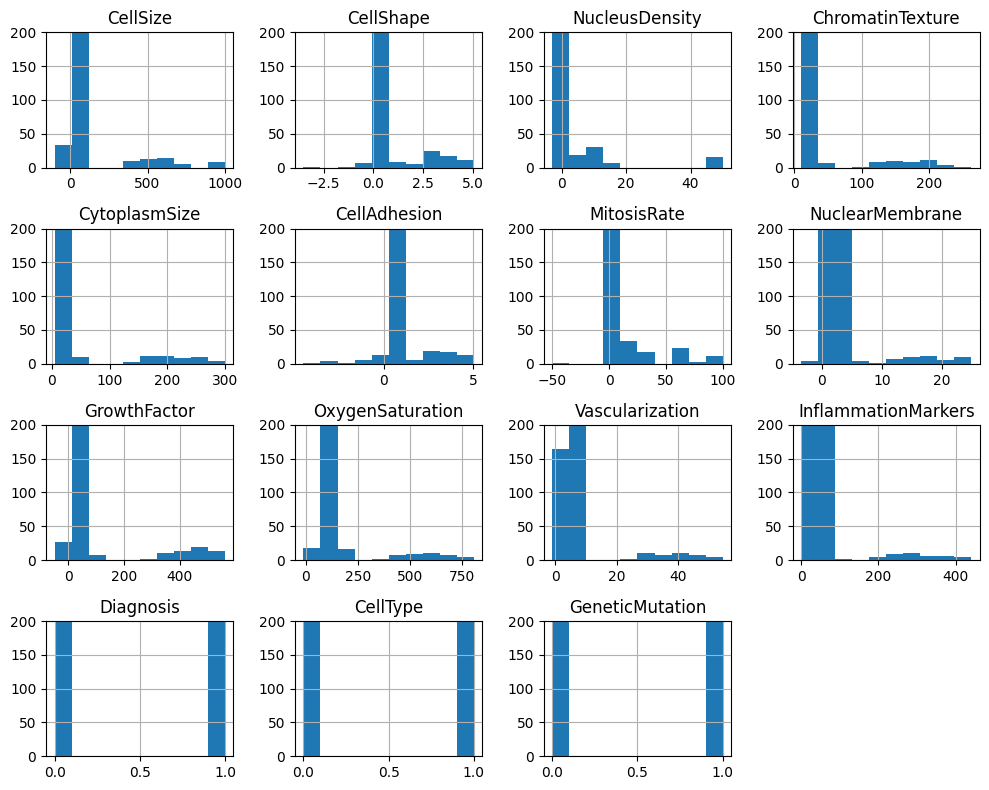

CellSize: barra más alta entre 46.67 y 83.33

CellShape: barra más alta entre 0.48 y 0.77

NucleusDensity: barra más alta entre 0.53 y 2.30

ChromatinTexture: barra más alta entre 18.46 y 26.92

CytoplasmSize: barra más alta entre 24.62 y 34.44

CellAdhesion: barra más alta entre 0.28 y 0.60

MitosisRate: barra más alta entre 0.00 y 5.00

NuclearMembrane: barra más alta entre 2.22 y 3.17

GrowthFactor: barra más alta entre 52.27 y 72.72

OxygenSaturation: barra más alta entre 71.72 y 98.96

Vascularization: barra más alta entre 4.55 y 6.40

InflammationMarkers: barra más alta entre 29.39 y 44.09

Diagnosis: barra más alta entre 0.00 y 0.03

CellType: barra más alta entre 0.00 y 0.03

GeneticMutation: barra más alta entre 0.97 y 1.00



In [26]:
from Problema1.src.preprocessing import label_encode
import numpy as np
df_dev = label_encode(df_dev, 'GeneticMutation', {"Presnt": 1, "Absnt": 0})
df_dev = label_encode(df_dev, 'CellType', {"Epthlial": 0, "Mesnchymal": 1})
df_test = label_encode(df_test, 'GeneticMutation', {"Presnt": 1, "Absnt": 0})
df_test = label_encode(df_test, 'CellType', {"Epthlial": 0, "Mesnchymal": 1})

df = pd.concat([df_dev, df_test])
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Matriz de correlación")
plt.show()

df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

df.hist(figsize=(10, 8))
for ax in plt.gcf().axes:
    ax.set_ylim(0, 200)
plt.tight_layout()
plt.show()

for col in df.select_dtypes(include=np.number).columns:
    counts, bins = np.histogram(df[col].dropna(), bins=30)
    max_bin = np.argmax(counts)
    print(f"{col}: barra más alta entre {bins[max_bin]:.2f} y {bins[max_bin+1]:.2f}\n")



In [27]:
def remove_outliers(df):
    """Elimina los outliers de las columnas numéricas.  
    Params: df (DataFrame).  
    """
    limits = {
    'CellSize': (0, np.inf), 'CellShape': (0, np.inf), 'CellAdhesion': (0, 1),
    'NucleusDensity': (0, np.inf), 'MitosisRate': (0, np.inf), 'NuclearMembrane': (1, 5), 
    'GrowthFactor': (0, np.inf), 'OxygenSaturation': (0, 100), 'Vascularization': (0, 10),
    'InflammationMarkers': (0, 100)
    }

    for col, (min_val, max_val) in limits.items():
        df[col] = df[col].where(df[col].between(min_val, max_val) | df[col].isna())

remove_outliers(df_dev)
remove_outliers(df_test)

In [28]:
import seaborn as sns
from Problema1.src.models import LinearRegression
import numpy as np

def get_knn(fila, df, col, k=5, features=None):
    """
    Devuelve los k vecinos más cercanos a 'fila' usando distancia euclídea.
    Params: fila (pd.Series), df (pd.DataFrame), col (str), k (int), features (list o None)
    Returns: pd.DataFrame con los k vecinos (features)
    """
    """Devuelve los k vecinos más cercanos a 'fila' usando distancia euclídea."""
    if features is None:
        features_validas = fila.drop(labels=[col]).dropna().index.tolist()
        features_df = df[features_validas].dropna()
    else:
        features_df = df[features].dropna()

    if features_df.empty:
        return None

    fila_vector = fila[features_df.columns].values
    diff = features_df.values - fila_vector
    dists = np.sqrt(np.sum(diff ** 2, axis=1))
    idx_sorted = np.argsort(dists)[:k]
    idx_vecinos = features_df.index[idx_sorted]

    return features_df.loc[idx_vecinos], idx_vecinos


def knn_regression(df, col, k=5, features=None, binary = False):
    """
    Realiza regresión KNN para predecir el valor de 'col' en 'fila'.
    Params: fila (pd.Series), df (pd.DataFrame), col (str), k (int), features (list o None)
    Returns: Predicción del valor de 'col' para la fila
    """
    # Separar filas con y sin el valor objetivo
    df_target = df[df[col].notna()]
    df_missing = df[df[col].isna()]

    for i, fila in df_missing.iterrows():
        vecinos, idxs = get_knn(fila, df_target, col, k=k, features=features)
        if vecinos is None:
            continue
        valores_target = df_target.loc[idxs, col]
        prediccion = valores_target.mean()
        if binary:
            prediccion = 1 if prediccion > 0.5 else 0
        df.at[i, col] = prediccion

columnas = [
    'CellSize', 'CellShape', 'NucleusDensity', 'ChromatinTexture', 'CytoplasmSize', 
    'CellAdhesion', 'MitosisRate', 'NuclearMembrane', 'GrowthFactor', 
    'OxygenSaturation', 'Vascularization', 'InflammationMarkers']
for col in columnas:
    knn_regression(df_dev, col, k=5)
    knn_regression(df_test, col, k=5)
knn_regression(df_dev, 'CellType', k=5, binary=True)
knn_regression(df_test, 'CellType', k=5, binary=True)
df = pd.concat([df_dev, df_test])
print("\nCategorías con valores faltantes\n", df.isna().sum()[df.isna().sum() > 0].to_string())

df_dev.to_csv("Problema1/data/processed/cell_diagnosis_balanced_dev.csv", index=False)
df_test.to_csv("Problema1/data/processed/cell_diagnosis_balanced_test.csv", index=False)


Categorías con valores faltantes
 Series([], )


### Ejercicio: Regresión Logística Binaria con Regularización L2

Implementar una **clase de regresión logística binaria** con **regularización L2**. Utilizando el conjunto de datos `cell_diagnosis_balanced_dev.csv`, realizar lo siguiente:

#### 🔹 División del conjunto
- Dividir los datos en:
  - **80 %** para entrenamiento
  - **20 %** para validación

#### 🔹 Ajuste de hiperparámetro
- Ajustar el hiperparámetro de regularización **λ** utilizando **F-Score** como métrica de performance.

> 📝 **Nota:** Si el modelo se implementa de forma general para clasificación multiclase, el mismo código podrá ser reutilizado en el ejercicio 2.


In [29]:
def train_val_split(dx, dy, split=0.8):
    """Divide dx y dy en conjuntos de entrenamiento y validación.  
    Params: dx (DataFrame), dy (Series), split (float). Returns: (dx_train, dx_val, dy_train, dy_val).
    """
    n = len(dx)
    n = int(n * split)
    x_train = dx[:n]
    x_val = dx[n:]
    y_train = dy[:n]
    y_val = dy[n:]
    return x_train, x_val, y_train, y_val

X = df_dev.drop("Diagnosis", axis=1)
y = df_dev["Diagnosis"]
X_train, X_val, y_train, y_val = train_val_split(X, y, split=0.8)

def standard_scaling(train, val):
    """Normaliza los datos con media y desviación estándar de train.  
    Params: train (DataFrame), val (DataFrame).  
    Returns: train_norm (DataFrame), val_norm (DataFrame), medias (Series), desv (Series).
    """
    medias = train.mean()
    desv = train.std()
    
    train_norm = (train - medias) / desv
    val_norm = (val - medias) / desv

    return train_norm, val_norm, medias, desv

def min_max_scaling(train, val):
    """Normaliza los datos con min y max de train.  
    Params: train (DataFrame), val (DataFrame).  
    Returns: train_norm (DataFrame), val_norm (DataFrame), minimos (Series), maximos (Series).
    """
    minimos = train.min()
    maximos = train.max()

    train_norm = (train - minimos) / (maximos - minimos)
    val_norm = (val - minimos) / (maximos - minimos)

    return train_norm, val_norm, minimos, maximos

features_standard = ['CellShape', 'NucleusDensity', 'MitosisRate', 'GrowthFactor', 'ChromatinTexture', 'CytoplasmSize']
features_minmax = ['NuclearMembrane', 'OxygenSaturation', 'Vascularization', 'InflammationMarkers']
X_train = X_train.copy()
X_val = X_val.copy()

print(X_train[features_standard].describe())


# X_train[features_standard], X_val[features_standard], medias, desv = standard_scaling(
#     X_train[features_standard], X_val[features_standard]
# )
# X_train[features_minmax], X_val[features_minmax], min, max = min_max_scaling(
#     X_train[features_minmax], X_val[features_minmax]
# )


         CellShape  NucleusDensity  MitosisRate  GrowthFactor  \
count  1330.000000     1330.000000  1330.000000   1330.000000   
mean      0.604067        2.304639     5.125673     75.132355   
std       0.551471        4.824276     9.775044     74.801697   
min       0.063622        0.097131     0.000000      0.000000   
25%       0.483181        1.399628     2.799128     58.237203   
50%       0.499986        1.449786     3.160663     60.887466   
75%       0.519218        1.489682     3.430104     62.954697   
max       5.048566       50.000000   100.000000    563.622684   

       ChromatinTexture  CytoplasmSize  
count       1330.000000    1330.000000  
mean          26.771105      33.764696  
std           26.680406      32.046604  
min           10.000000       5.000000  
25%           21.292112      26.399093  
50%           22.070156      28.233051  
75%           22.790964      30.375557  
max          263.793425     277.518970  


In [30]:
from Problema1.src.models import LogisticRegression 

def precision(y_true, y_pred):
    """Calcula la precisión de las predicciones.  
    Params: y_true (Series), y_pred (Series). Returns: float.
    """
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    predicted_positives = np.sum(y_pred == 1)
    return true_positives / predicted_positives if predicted_positives != 0 else -1

def recall(y_true, y_pred):
    """Calcula el recall de las predicciones.  
    Params: y_true (Series), y_pred (Series). Returns: float.
    """
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    actual_positives = np.sum(y_true == 1)
    return true_positives / actual_positives if actual_positives != 0 else -1

def f_score(y_true, y_pred):
    """Calcula el F-score de las predicciones.
    Params: y_true (Series), y_pred (Series), beta (float). Returns: float.
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    if p == -1 or r == -1 or p + r == 0:
        return -1
    return 2 * (p * r) / (p + r)

lambdas = [0, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
scores = []
for l in lambdas:
    model = LogisticRegression(X_train, y_train, L2=l)
    y_pred = model.predict(X_val)
    fs = f_score(y_val, y_pred)
    print(f"Lambda: {l}, F-score: {fs:.4f}")


Lambda: 0, F-score: 0.2591
Lambda: 0.0001, F-score: 0.2591
Lambda: 0.001, F-score: 0.2408
Lambda: 0.01, F-score: 0.7305
Lambda: 0.1, F-score: 0.7162
Lambda: 1, F-score: 0.9012
Lambda: 10, F-score: 0.6600


c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:77: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Lambda: 100, F-score: 0.6600


#### 🔹 Entrenamiento y evaluación
- Entrenar el modelo sobre el conjunto de entrenamiento.
- Evaluar el desempeño sobre el conjunto de validación.

#### 🔹 Reportar métricas de performance
- Matriz de confusión
- Accuracy
- Precision
- Recall
- F-Score
- Curva Precision-Recall (PR)
- Curva ROC
- AUC-ROC
- AUC-PR


Matriz de confusión:


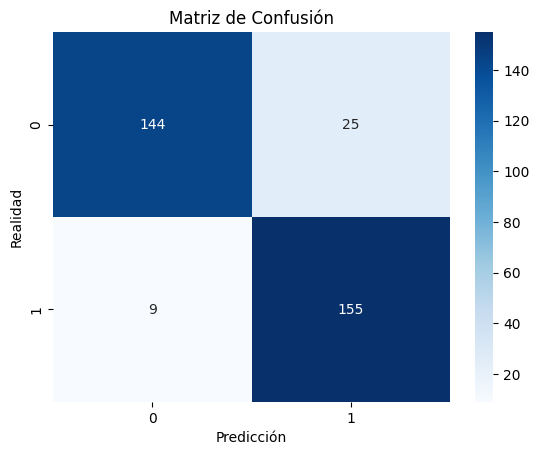


Accuracy del modelo: 0.8978978978978979
Precisión del modelo: 0.8611111111111112
Recall del modelo: 0.9451219512195121
F-score del modelo: 0.9011627906976744

Curva de precisión-recall:


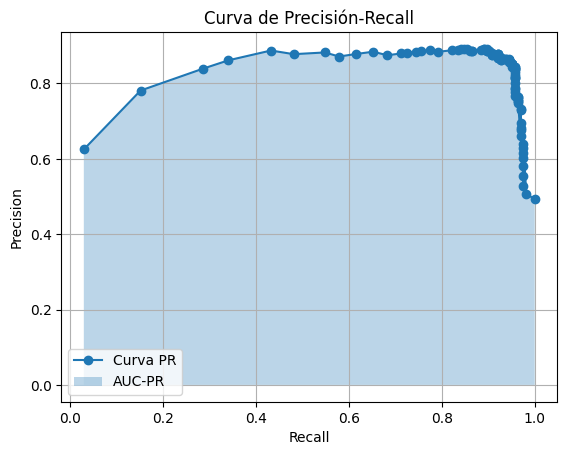

AUC-PR: 0.8083353895034694

Curva ROC:


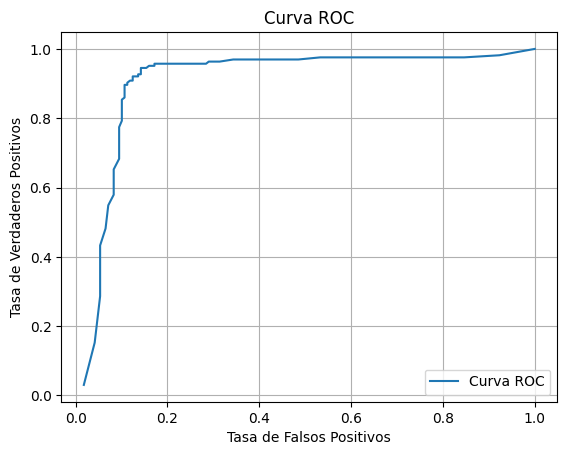

AUC-ROC: 0.9038641939673834


In [31]:
def matriz_de_confusion(y_true, y_pred):
    """Calcula y muestra la matriz de confusión.  
    Params: y_true (Series), y_pred (Series). Returns: None.
    """
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    cm = np.array([[tn, fp], [fn, tp]])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.title('Matriz de Confusión')
    plt.show()

def accuracy(y_true, y_pred):
    """Calcula la precisión del modelo.  
    Params: y_true (Series), y_pred (Series). Returns: float.
    """
    return np.mean(y_true == y_pred)

def plot_pr(y_true, y_pred):
    """Genera la curva de precisión-recall.  
    Params: y_true (Series), y_pred (Series). Returns: None.
    """
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []

    for t in thresholds:
        y_pred_t = (y_pred >= t).astype(int)
        p = precision(y_true, y_pred_t)
        r = recall(y_true, y_pred_t)
        precisions.append(p)
        recalls.append(r)

    # Ordenar por recall (eje x)
    recalls, precisions = zip(*sorted(zip(recalls, precisions)))

    # Graficar curva y área
    plt.plot(recalls, precisions, marker='o', label='Curva PR')
    plt.fill_between(recalls, precisions, alpha=0.3, label='AUC-PR')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva de Precisión-Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

    auc_pr = np.trapz(precisions, recalls)
    return auc_pr

def plot_roc(y_true, y_scores):
    """Genera la curva ROC.
    Params: y_true (Series), y_scores (Series). Returns: None.
    """
    thresholds = np.linspace(0, 1, 100)
    tpr = []
    fpr = []
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    
    sorted_pairs = sorted(zip(fpr, tpr))
    fpr_sorted, tpr_sorted = zip(*sorted_pairs)

    plt.plot(fpr_sorted, tpr_sorted, label='Curva ROC')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

    auc_roc = np.trapz(tpr_sorted, fpr_sorted)
    return auc_roc

model = LogisticRegression(X_train, y_train, L2=1)
y_pred = model.predict(X_val)
print("\nMatriz de confusión:")
matriz_de_confusion(y_val, y_pred)
print("\nAccuracy del modelo:", accuracy(y_val, y_pred))
print("Precisión del modelo:", precision(y_val, y_pred))
print("Recall del modelo:", recall(y_val, y_pred))
print("F-score del modelo:", f_score(y_val, y_pred))

y_scores = model.predict_proba(X_val)
print("\nCurva de precisión-recall:")
auc_pr = plot_pr(y_val, y_scores)
print("AUC-PR:", auc_pr)
print("\nCurva ROC:")
auc_roc = plot_roc(y_val, y_scores)
print("AUC-ROC:", auc_roc)


Matriz de confusión:


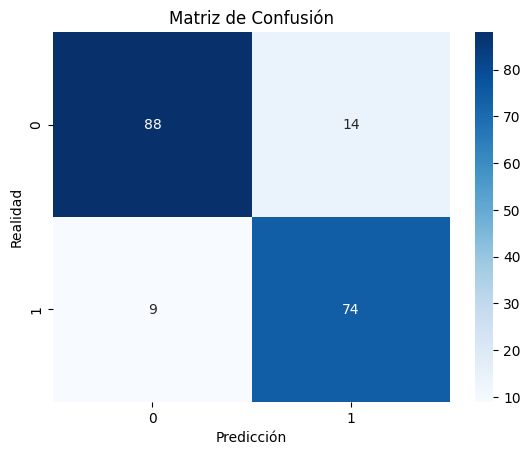


Accuracy del modelo: 0.8756756756756757
Precisión del modelo: 0.8409090909090909
Recall del modelo: 0.891566265060241
F-score del modelo: 0.8654970760233919

Curva de precisión-recall:


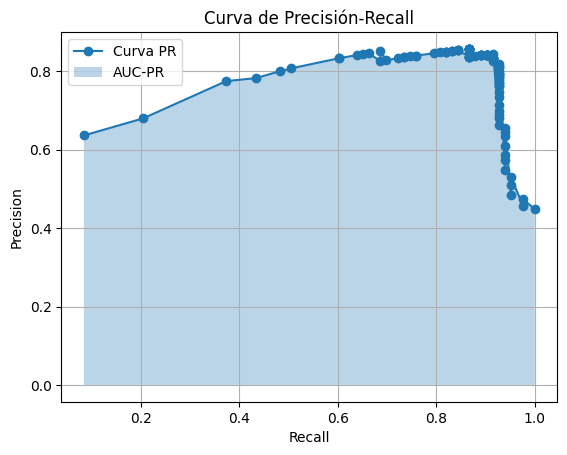

AUC-PR: 0.6961923852996064

Curva ROC:


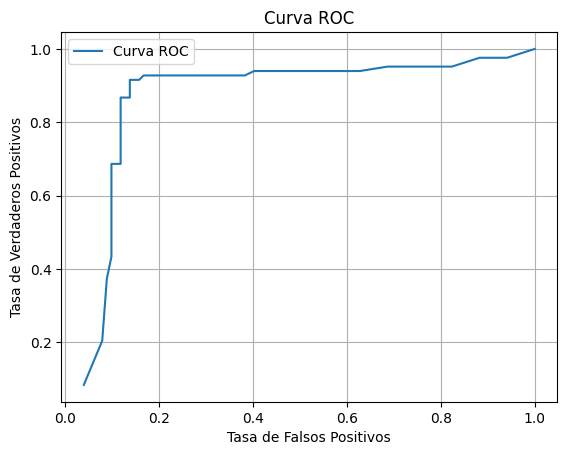

AUC-ROC: 0.8587290337821876


In [32]:
X_test = df_test.drop("Diagnosis", axis=1)
y_test = df_test["Diagnosis"]
y_pred = model.predict(X_test)
print("\nMatriz de confusión:")
matriz_de_confusion(y_test, y_pred)
print("\nAccuracy del modelo:", accuracy(y_test, y_pred))
print("Precisión del modelo:", precision(y_test, y_pred))
print("Recall del modelo:", recall(y_test, y_pred))
print("F-score del modelo:", f_score(y_test, y_pred))

y_scores = model.predict_proba(X_test)
print("\nCurva de precisión-recall:")
auc_pr = plot_pr(y_test, y_scores)
print("AUC-PR:", auc_pr)
print("\nCurva ROC:")
auc_roc = plot_roc(y_test, y_scores)
print("AUC-ROC:", auc_roc)

## 1.4. Rebalanceo de Clases en Conjuntos Desbalanceados

Utilizando el conjunto de datos `cell_diagnosis_imbalanced_dev.csv`, dividir los datos en 80 % entrenamiento y 20 % validación. Entrenar distintos modelos de regresión logística binaria con regularización L2, aplicando una técnica de re-balanceo distinta en cada caso:

### Técnicas a evaluar:

1. **Sin rebalanceo**  
   Entrenar el modelo directamente sobre los datos desbalanceados.

2. **Undersampling**  
   Eliminar muestras de la clase mayoritaria de manera aleatoria hasta que ambas clases tengan igual proporción.

3. **Oversampling por duplicación**  
   Duplicar muestras de la clase minoritaria de manera aleatoria hasta igualar proporciones.

4. **Oversampling con SMOTE**  
   Generar muestras sintéticas de la clase minoritaria usando SMOTE hasta igualar proporciones.

5. **Cost re-weighting**  
   Modificar la función de costo para ponderar más los errores en la clase minoritaria.  
   Multiplicar los términos asociados a esta clase por un factor:  
   \[
   C = \frac{\pi_2}{\pi_1}
   \]
   donde π₁ es la proporción de la clase minoritaria y π₂ la de la clase mayoritaria.

---

### Evaluación

Evaluar cada modelo sobre el conjunto de validación usando las siguientes métricas:

- Matriz de Confusión  
- Accuracy  
- Precision  
- Recall  
- F-Score  
- Curva Precision-Recall (PR)  
- Curva ROC  
- AUC-ROC  
- AUC-PR  

Para ajustar el hiperparámetro de regularización λ, usar **F-Score** como métrica de performance.

---

### Visualización

- **Curvas ROC**: graficar todas en un solo gráfico para comparar.
- **Curvas PR**: idem.
- **Tabla de métricas**: reunir métricas escalares en una tabla como esta:

| Método                 | Accuracy | Precision | Recall | F-Score | AUC-ROC | AUC-PR |
|------------------------|----------|-----------|--------|---------|---------|--------|
| Sin rebalanceo         |          |           |        |         |         |        |
| Undersampling          |          |           |        |         |         |        |
| Oversampling duplicado |          |           |        |         |         |        |
| SMOTE                  |          |           |        |         |         |        |
| Cost re-weighting      |          |           |        |         |         |        |
s